# Requirement 5

In [1]:
import numpy as np


class PricingEnvConversion:
    def __init__(self, intervals, B, T, n_customers=100):
        """
        intervals: list of dicts, each defining an interval with:
            - 'start': starting round index (inclusive)
            - 'end': ending round index (exclusive)
            - 'mu': N x P profit matrix for that interval
            - 'conversion_fn': function mapping price_idx -> buy prob
        B: total cumulative inventory across all rounds
        T: total number of rounds
        n_customers: number of potential buyers per round
        """
        self.intervals = intervals
        self.T = T
        self.n_customers = n_customers
        self.t = 0
        self.N, self.P = intervals[0]['mu'].shape
        self._set_interval(0)

    def _set_interval(self, idx):
        """Set mu and conversion function for the current interval"""
        self.current_interval = idx
        self.mu = self.intervals[idx]['mu']
        self.conversion_fn = self.intervals[idx]['conversion_fn']

    def round(self, price_vector):
        """
        Arguments:
            price_vector: list of chosen price indices per product (-1 = do not sell)
        Returns:
            demand: units sold per product
            profit: reward per product
        """
        if self.t >= self.T:
            raise Exception("Environment finished all rounds.")

        # Check if interval should change
        if self.current_interval < len(self.intervals) - 1:
            if self.t >= self.intervals[self.current_interval]['end']:
                self._set_interval(self.current_interval + 1)

        rewards_per_unit = np.zeros(self.N)
        demand = np.zeros(self.N, dtype=int)
        profit = np.zeros(self.N)

        for i in range(self.N):
            price_idx = price_vector[i]
            if price_idx == -1:
                # skip this product
                continue
            # compute reward and demand
            rewards_per_unit[i] = self.mu[i, price_idx]
            prob = self.conversion_fn(price_idx)
            demand[i] = np.random.binomial(self.n_customers, prob)
            profit[i] = rewards_per_unit[i] * demand[i]

        self.t += 1
        return demand, profit

In [2]:
from collections import deque
import numpy as np
from scipy import optimize

class CombinatorialUCB:
    def __init__(self, N, P, B, T, window_size=100):
        """
        N: number of products
        P: number of prices
        B: shared capacity (total inventory)
        T: total number of rounds
        window_size: number of past rounds to keep in the sliding window
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.window_size = window_size
        self.reset()

    def reset(self):
        """Reset agent state for a new simulation"""
        self.remaining_inventory = self.B
        self.t = 0
        # Sliding window: store last window_size rounds
        self.rewards_window = deque(maxlen=self.window_size)       
        self.consumptions_window = deque(maxlen=self.window_size)  

    def pull_arm(self):
        if self.remaining_inventory < 1:
            return [-1] * self.N

        # Compute empirical means and average consumptions from sliding window
        if len(self.rewards_window) == 0:
            means = np.zeros((self.N, self.P))
            avg_c = np.zeros((self.N, self.P))
            counts = np.zeros((self.N, self.P))
        else:
            rewards_stack = np.stack(self.rewards_window, axis=0)       # shape: window_size x N x P
            consumptions_stack = np.stack(self.consumptions_window, axis=0)
            counts = np.sum(rewards_stack != 0, axis=0)
            means = np.sum(rewards_stack, axis=0) / np.maximum(1, counts)
            avg_c = np.sum(consumptions_stack, axis=0) / np.maximum(1, counts)

        # Initial exploration
        if self.t < self.P:
            return [self.t % self.P for _ in range(self.N)]

        f_ucbs = means + np.sqrt(2*np.log(self.t) / (counts + 1e-6))
        c_lcbs = avg_c - np.sqrt(2*np.log(self.t) / (counts + 1e-6))

        rho = self.remaining_inventory / max(1, self.T - self.t)

        # solve LP to compute probabilities over prices
        gamma = self.compute_opt(f_ucbs, c_lcbs, rho)

        prices = []
        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum() + 1e-8
            choice = np.random.choice(len(probs), p=probs)
            prices.append(-1 if choice == 0 else choice - 1)

        return prices

    def compute_opt(self, f_ucbs, c_lcbs, rho):
        N, P = self.N, self.P
        f_ucbs = np.hstack([np.zeros((N,1)), f_ucbs])
        c_lcbs = np.hstack([np.zeros((N,1)), c_lcbs])
        c_obj = -f_ucbs.flatten()
        bounds = [(0,1) for _ in range(N*(P+1))]

        # equality: each row sums to 1
        A_eq = np.zeros((N, N*(P+1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P+1):
                A_eq[i, i*(P+1)+j] = 1

        # inequality: expected cost <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        res = optimize.linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
        if res.success:
            return res.x.reshape(N, P+1)
        else:
            return np.zeros((N, P+1))

    def update(self, prices, demand, rewards):
        """
        Update sliding-window estimates with observed data.
        Arguments:
            prices: list of chosen price indices per product (-1 if product not sold)
            demand: observed demand per product
            rewards: observed per-product reward
        """
        self.t += 1
        self.remaining_inventory = max(0, self.remaining_inventory - sum(demand))

        # Construct this round's matrices
        rewards_mat = np.zeros((self.N, self.P))
        consumption_mat = np.zeros((self.N, self.P))
        for i in range(self.N):
            p = prices[i]
            if p != -1:
                rewards_mat[i,p] = rewards[i]
                consumption_mat[i,p] = demand[i]

        # append them to the sliding window
        self.rewards_window.append(rewards_mat)
        self.consumptions_window.append(consumption_mat)


In [3]:
def clairvoyant_sample_action(gamma, f):
    """
    Args:
        gamma: (N x (P+1)) array of action probabilities from the LP,
               where the first column is the "do not sell" option.
        f: (N x P) array of true expected rewards for each product/price pair.

    Returns:
        sampled_action: list of chosen price indices per product
                        (-1 indicates "do not sell").
        expected_reward_per_round: sum of expected rewards across products
                                   for the sampled action (already accounts for n_customers)
    """

    N, _ = gamma.shape

    sampled_action = []
    expected_reward_per_round = 0.0
    for i in range(N):
        probs = np.clip(gamma[i], 0, None)
        if probs.sum() > 0:
            probs /= probs.sum()
        else:
            probs = np.zeros_like(probs)
            probs[0] = 1  # fallback: "do not sell"
        idx = np.random.choice(len(probs), p=probs)
        if idx == 0:
            sampled_action.append(-1)
        else:
            sampled_action.append(idx-1)
            expected_reward_per_round += f[i, idx-1]

    return sampled_action, expected_reward_per_round

In [4]:
from collections import deque


class DualAgent:
    def __init__(self, N, P, B, T, window_size=100):
        """
        N: number of products
        P: number of prices
        B: shared capacity (total inventory)
        T: total number of rounds
        window_size: number of past rounds to keep in the sliding window
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.window_size = window_size

        self.lambda_ = 0

        self.reset()

    def reset(self):
        """Reset agent state for a new simulation"""
        self.remaining_inventory = self.B
        self.t = 0
        # Sliding window: store last window_size rounds
        self.rewards_window = deque(maxlen=self.window_size)       
        self.consumptions_window = deque(maxlen=self.window_size)  

        self.lambda_ = 0

    def pull_arm(self):
        """
        Pull arm using primal-dual approach with sliding window statistics.
        
        Parameters
        ----------
        lam : float
            Current dual variable λ (shadow price of capacity)
        
        Returns
        -------
        prices : list of int
            Selected price index for each product (-1 = not offered)
        """
        if self.remaining_inventory < 1:
            return [-1] * self.N

        # --- Compute empirical means and average consumptions from sliding window ---
        if len(self.rewards_window) == 0:
            means = np.zeros((self.N, self.P))
            avg_c = np.zeros((self.N, self.P))
            counts = np.zeros((self.N, self.P))
        else:
            rewards_stack = np.stack(self.rewards_window, axis=0)       # shape: window_size x N x P
            consumptions_stack = np.stack(self.consumptions_window, axis=0)
            counts = np.sum(rewards_stack != 0, axis=0)
            means = np.sum(rewards_stack, axis=0) / np.maximum(1, counts)
            avg_c = np.sum(consumptions_stack, axis=0) / np.maximum(1, counts)

        # --- Initial exploration: pick different price for each product ---
        if self.t < self.P:
            return [self.t % self.P for _ in range(self.N)]

        # --- Primal-dual step: compute optimal probability distribution ---
        # Use empirical means for reward and consumption, and current lambda
        #if(self.t % 10 == 0):
            #print("My current means is")
            #print(means)
            #print("My current avg_c is")
            #print(avg_c)
            #print("My current lambda is")
            #print(self.lambda_)

        gamma = self.compute_opt(means, avg_c, self.lambda_)

        # --- Sample prices for each product from computed distribution ---
        prices = []
        for i in range(self.N):
            probs = np.clip(gamma[i], 0, None)
            probs /= probs.sum() + 1e-8  # normalize to make it a valid distribution
            choice = np.random.choice(len(probs), p=probs)
            prices.append(-1 if choice == 0 else choice - 1)  # 0 = not offered

        return prices
        
    def compute_opt(self, f_means, c_means, lambda_):
        """
        Compute optimal product/price distribution under primal-dual Lagrangian.

        Parameters
        ----------
        f_means : np.ndarray, shape (N, P)
            Empirical mean rewards for each product i and price option j
        c_means : np.ndarray, shape (N, P)
            Empirical mean consumptions (units) for each product i and price option j
        lam : float
            Current dual variable λ (shadow price of capacity)

        Returns
        -------
        policy : np.ndarray, shape (N, P+1)
            Probability distribution over actions for each product.
            Column 0 corresponds to "not offering the product".
        """
        N, P = self.N, self.P

        # Add dummy "not offering" option (zero reward, zero cost)
        f_means = np.hstack([np.zeros((N, 1)), f_means])
        c_means = np.hstack([np.zeros((N, 1)), c_means])

        # Build objective coefficients: reward minus λ * cost
        obj = (f_means - lambda_ * c_means).flatten()

        # Constraints: each product must choose exactly one action
        A_eq = np.zeros((N, N * (P + 1)))
        b_eq = np.ones(N)
        for i in range(N):
            for j in range(P + 1):
                A_eq[i, i * (P + 1) + j] = 1

        # Bounds: each variable is in [0,1]
        bounds = [(0, 1) for _ in range(N * (P + 1))]

        # Solve LP (maximize linear function → minimize negative)
        res = optimize.linprog(
            c=-obj,
            A_eq=A_eq, b_eq=b_eq,
            bounds=bounds,
            method="highs"
        )

        if res.success:
            return res.x.reshape(N, P + 1)
        else:
            # fallback: uniform distribution over all options (including "not offer")
            return np.ones((N, P + 1)) / (P + 1)
        

    def update(self, prices, demand, rewards):
        """
        Update sliding-window estimates and dual variable with observed data.

        Arguments:
            prices: list of chosen price indices per product (-1 if product not offered)
            demand: observed demand per product
            rewards: observed per-product reward
        """
        self.t += 1

        # --- Update remaining inventory ---
        total_consumed = sum(demand)
        self.remaining_inventory = max(0, self.remaining_inventory - total_consumed)

        # --- Construct this round's matrices for sliding window ---
        rewards_mat = np.zeros((self.N, self.P))
        consumption_mat = np.zeros((self.N, self.P))
        for i in range(self.N):
            p = prices[i]
            if p != -1:
                rewards_mat[i, p] = rewards[i]
                consumption_mat[i, p] = demand[i]

        # --- Append to sliding window ---
        self.rewards_window.append(rewards_mat)
        self.consumptions_window.append(consumption_mat)

        # --- Update dual variable lambda (primal-dual) ---
        # rho = per-round budget allowance
        rho = self.remaining_inventory / max(1, self.T - self.t)
        #eta = 0.1 / self.N
        eta = 0.005 / self.N
        self.lambda_ = max(0, self.lambda_ + eta * (total_consumed - rho))

Round 0: Interval 0
  Agent prices: [0, 0], Reward: 3.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: 24.000

Round 1000: Interval 0
  Agent prices: [2, 2], Reward: 42.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: -0.823

Round 2000: Interval 0
  Agent prices: [0, 2], Reward: 2.00
  Clairvoyant prices: [-1, 2], Reward: 18.00
  Cumulative regret / t: -0.326

Round 3000: Interval 1
  Agent prices: [-1, 0], Reward: 30.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.065

Round 4000: Interval 1
  Agent prices: [-1, 0], Reward: 12.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.200

Round 5000: Interval 1
  Agent prices: [-1, 0], Reward: 30.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.175

Round 6000: Interval 1
  Agent prices: [-1, 0], Reward: 24.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: -0.125

Round 7000: Interval 1
  Agen

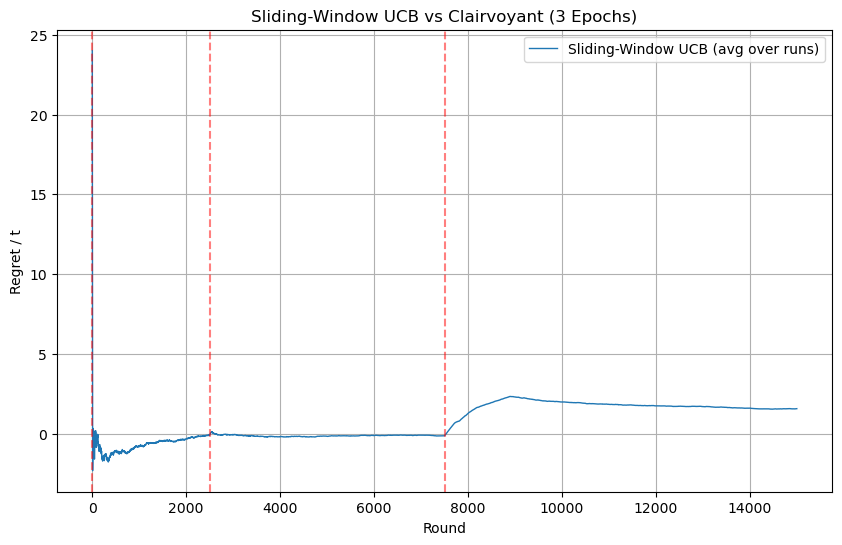

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


# Example conversion functions
def conv_fn_1(price_idx):
    return 0.1 * (price_idx + 1)

def conv_fn_2(price_idx):
    return 0.5 - 0.1 * price_idx

def conv_fn_3(price_idx):
    return 0.2 + 0.05 * price_idx


# Example mu matrices
mu1 = np.array([[1, 2, 3],
                [2, 4, 6]])
mu2 = np.array([[3, 2, 1],
                [6, 4, 2]])
mu3 = np.array([[2, 3, 4],
                [3, 6, 9]])


# Define intervals (3 epochs in this case)
l = 5000

intervals = [
    {'start': 0, 'end': l*0.5, 'mu': mu1, 'conversion_fn': conv_fn_1},
    {'start': l*0.5, 'end': l*1.5, 'mu': mu2, 'conversion_fn': conv_fn_2},
    {'start': l*1.5, 'end': l*3, 'mu': mu3, 'conversion_fn': conv_fn_3}
]

# Simulation parameters
N, P = intervals[0]['mu'].shape
n_customers = 10

T_total = l*3
window_size = round(0.35 * l)
#n_runs = 8
n_runs = 1
checkpoint_interval = 1000  # print checkpoint every 1000 rounds
B = round(T_total * n_customers * N * 0.25)


# Run simulations
all_regret_ratios = []
final_regret_ratios = []

env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

#agent_clar = DualAgent(N=N, P=P, B=B, T=T_total, window_size=window_size)

clairvoyant_solutions = []

rho_clar = B / T_total

for interval in intervals:
    mu = np.array(interval['mu'])
    conversion_fn = interval['conversion_fn']

    # f: expected reward per product/price
    f = mu * np.array([conversion_fn(p) for p in range(P)]) * n_customers

    # c: expected cost per product/price
    c = np.array([[conversion_fn(p) for p in range(P)] for _ in range(N)]) * n_customers

    gamma_clar = agent.compute_opt(f, c, rho_clar)
    #gamma_clar = agent_clar.compute_opt(f, c, rho_clar)

    clairvoyant_solutions.append({
        "start": interval['start'],
        "end": interval['end'],
        "f": f,
        "c": c,
        "rho": rho_clar,
        "gamma": gamma_clar
    })


for seed in range(n_runs):
    np.random.seed(seed)
    
    env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
    agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)
    agent.reset()  # ensure sliding windows are empty
    
    cumulative_regret = 0
    regret_ratio_per_round = []

    # Added for graphs later
    prices_per_round = []  # store agent prices per round
    agent_rewards = []      # reward obtained by agent each round
    clair_rewards = []      # reward obtained by clairvoyant each round
    agent_inventory_over_time = []


    for t in range(env.T):

        price_vector = agent.pull_arm()
        demand, profit = env.round(price_vector)
        total_reward = profit.sum()

        prices_per_round.append(price_vector.copy())

        # Update agent
        agent.update(price_vector, demand, profit)
        
        agent_inventory_over_time.append(agent.remaining_inventory)

        # Clairvoyant sample its action (via LP solution)
        interval_idx = env.current_interval
        clair_info = clairvoyant_solutions[interval_idx]
        gamma = clair_info["gamma"]
        f = clair_info["f"]

        # Sample clairvoyant action + reward for this round
        clair_action, clair_reward_per_round = clairvoyant_sample_action(gamma, f)

        agent_rewards.append(total_reward)
        clair_rewards.append(clair_reward_per_round)

        # Update cumulative regret
        cumulative_regret += clair_reward_per_round - total_reward
        regret_ratio_per_round.append(cumulative_regret / (t + 1))

        # Print checkpoint
        if t % checkpoint_interval == 0:
            print(f"Round {t}: Interval {interval_idx}")
            print(f"  Agent prices: {price_vector}, Reward: {total_reward:.2f}")
            print(f"  Clairvoyant prices: {clair_action}, Reward: {clair_reward_per_round:.2f}")
            print(f"  Cumulative regret / t: {cumulative_regret / (t + 1):.3f}\n")

    all_regret_ratios.append(regret_ratio_per_round)
    
    # Save final regret ratio for this run
    final_ratio = regret_ratio_per_round[-1]
    final_regret_ratios.append(final_ratio)
    print(f"Run {seed+1}/{n_runs} finished. Final regret ratio: {final_ratio:.4f}")


avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
avg_final_regret_ratio = np.mean(final_regret_ratios)

# Summary print
print("\n=======================")
print("Summary of final regret ratios:")
for i, val in enumerate(final_regret_ratios, 1):
    print(f"  Run {i}: Final regret ratio = {val:.4f}")
print(f"  Average final regret ratio across runs = {avg_final_regret_ratio:.4f}")
print("=======================\n")



plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_regret_ratio, lw=1, label="Sliding-Window UCB (avg over runs)")

for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)

plt.xlabel("Round")
plt.ylabel("Regret / t")
plt.title("Sliding-Window UCB vs Clairvoyant (3 Epochs)")
plt.grid(True)
plt.legend()
plt.show()


Round 0: Interval 0
  Agent prices: [0, 0], Reward: 3.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: 24.000

Round 1000: Interval 0
  Agent prices: [2, 2], Reward: 27.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: -3.129

Round 2000: Interval 0
  Agent prices: [2, 2], Reward: 27.00
  Clairvoyant prices: [2, 2], Reward: 27.00
  Cumulative regret / t: -1.934

Round 3000: Interval 1
  Agent prices: [-1, 2], Reward: 6.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 2.529

Round 4000: Interval 1
  Agent prices: [2, 2], Reward: 10.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 7.502

Round 5000: Interval 1
  Agent prices: [2, 2], Reward: 7.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 10.449

Round 6000: Interval 1
  Agent prices: [2, 2], Reward: 14.00
  Clairvoyant prices: [-1, 0], Reward: 30.00
  Cumulative regret / t: 12.392

Round 7000: Interval 1
  Agent prices

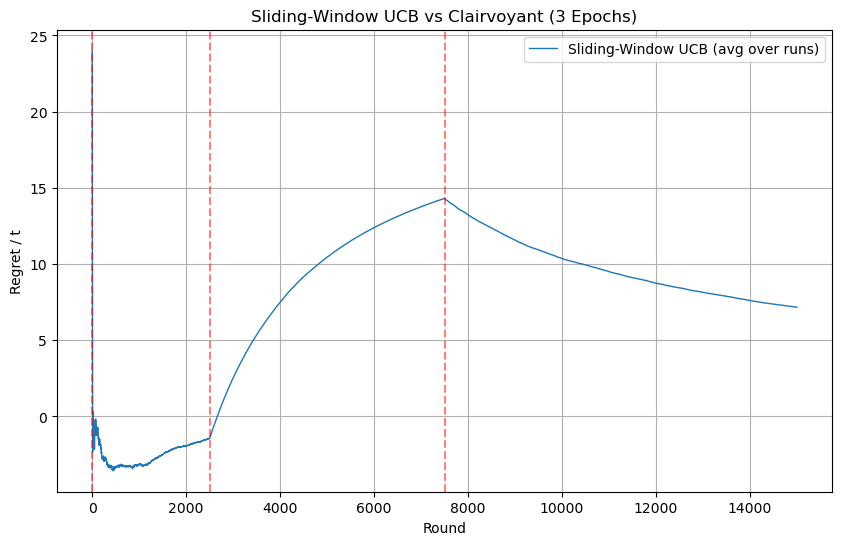

In [6]:
# Run simulations
all_regret_ratios = []
final_regret_ratios = []

env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
agent_clar = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

agent = DualAgent(N=N, P=P, B=B, T=T_total, window_size=window_size)

clairvoyant_solutions = []

rho_clar = B / T_total

for interval in intervals:
    mu = np.array(interval['mu'])
    conversion_fn = interval['conversion_fn']

    # f: expected reward per product/price
    f = mu * np.array([conversion_fn(p) for p in range(P)]) * n_customers

    # c: expected cost per product/price
    c = np.array([[conversion_fn(p) for p in range(P)] for _ in range(N)]) * n_customers

    gamma_clar = agent_clar.compute_opt(f, c, rho_clar)

    clairvoyant_solutions.append({
        "start": interval['start'],
        "end": interval['end'],
        "f": f,
        "c": c,
        "rho": rho_clar,
        "gamma": gamma_clar
    })


for seed in range(n_runs):
    np.random.seed(seed)
    
    env = PricingEnvConversion(intervals=intervals, B=B, T=T_total, n_customers=n_customers)
    #agent = CombinatorialUCB(N=N, P=P, B=B, T=T_total, window_size=window_size)

    agent = DualAgent(N=N, P=P, B=B, T=T_total, window_size=window_size)

    agent.reset()  # ensure sliding windows are empty
    
    cumulative_regret = 0
    regret_ratio_per_round = []

    # Added for graphs later
    prices_per_round = []  # store agent prices per round
    agent_rewards = []      # reward obtained by agent each round
    clair_rewards = []      # reward obtained by clairvoyant each round
    agent_inventory_over_time = []


    for t in range(env.T):

        price_vector = agent.pull_arm()
        demand, profit = env.round(price_vector)
        total_reward = profit.sum()

        prices_per_round.append(price_vector.copy())

        # Update agent
        agent.update(price_vector, demand, profit)
        
        agent_inventory_over_time.append(agent.remaining_inventory)

        # Clairvoyant sample its action (via LP solution)
        interval_idx = env.current_interval
        clair_info = clairvoyant_solutions[interval_idx]
        gamma = clair_info["gamma"]
        f = clair_info["f"]

        # Sample clairvoyant action + reward for this round
        clair_action, clair_reward_per_round = clairvoyant_sample_action(gamma, f)

        agent_rewards.append(total_reward)
        clair_rewards.append(clair_reward_per_round)

        # Update cumulative regret
        cumulative_regret += clair_reward_per_round - total_reward
        regret_ratio_per_round.append(cumulative_regret / (t + 1))

        # Print checkpoint
        if t % checkpoint_interval == 0:
            print(f"Round {t}: Interval {interval_idx}")
            print(f"  Agent prices: {price_vector}, Reward: {total_reward:.2f}")
            print(f"  Clairvoyant prices: {clair_action}, Reward: {clair_reward_per_round:.2f}")
            print(f"  Cumulative regret / t: {cumulative_regret / (t + 1):.3f}\n")

    all_regret_ratios.append(regret_ratio_per_round)
    
    # Save final regret ratio for this run
    final_ratio = regret_ratio_per_round[-1]
    final_regret_ratios.append(final_ratio)
    print(f"Run {seed+1}/{n_runs} finished. Final regret ratio: {final_ratio:.4f}")


avg_regret_ratio = np.mean(all_regret_ratios, axis=0)
avg_final_regret_ratio = np.mean(final_regret_ratios)

# Summary print
print("\n=======================")
print("Summary of final regret ratios:")
for i, val in enumerate(final_regret_ratios, 1):
    print(f"  Run {i}: Final regret ratio = {val:.4f}")
print(f"  Average final regret ratio across runs = {avg_final_regret_ratio:.4f}")
print("=======================\n")

plt.figure(figsize=(10,6))
plt.plot(range(T_total), avg_regret_ratio, lw=1, label="Sliding-Window UCB (avg over runs)")

for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)

plt.xlabel("Round")
plt.ylabel("Regret / t")
plt.title("Sliding-Window UCB vs Clairvoyant (3 Epochs)")
plt.grid(True)
plt.legend()
plt.show()

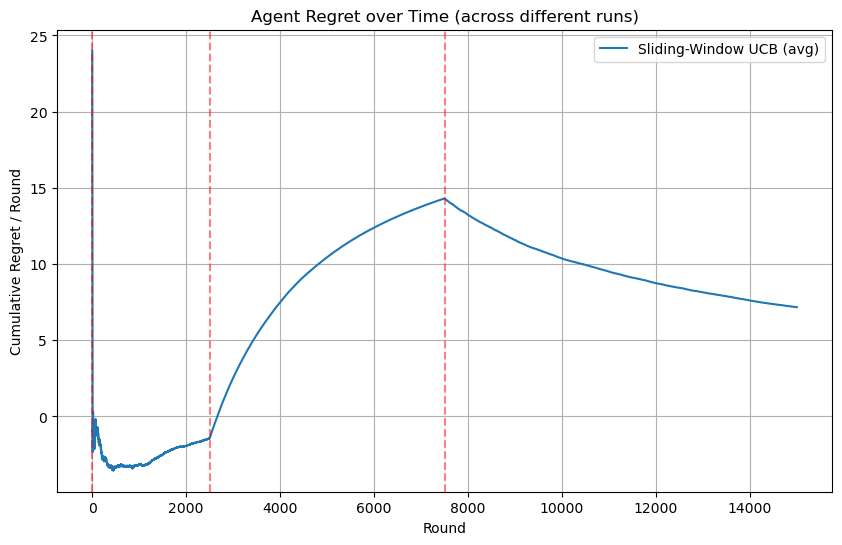

In [7]:
plt.figure(figsize=(10,6))
avg_regret = np.mean(all_regret_ratios, axis=0)
std_regret = np.std(all_regret_ratios, axis=0)
plt.plot(avg_regret, label="Sliding-Window UCB (avg)")
plt.fill_between(range(T_total), avg_regret-std_regret, avg_regret+std_regret, alpha=0.2)
for interval in intervals:
    plt.axvline(interval['start'], color='red', linestyle='--', alpha=0.5)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret / Round")
plt.title("Agent Regret over Time (across different runs)")
plt.grid(True)
plt.legend()
plt.show()

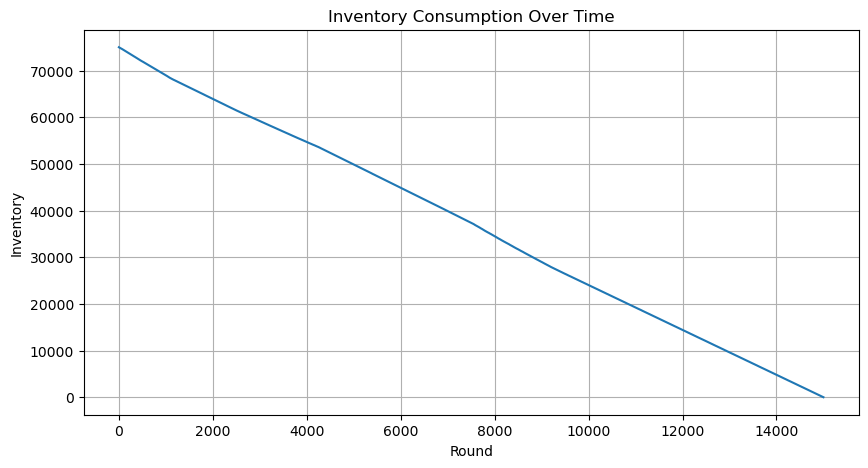

In [8]:
plt.figure(figsize=(10,5))
plt.plot(agent_inventory_over_time, label="Remaining Inventory")
plt.xlabel("Round")
plt.ylabel("Inventory")
plt.title("Inventory Consumption Over Time")
plt.grid(True)
plt.show()

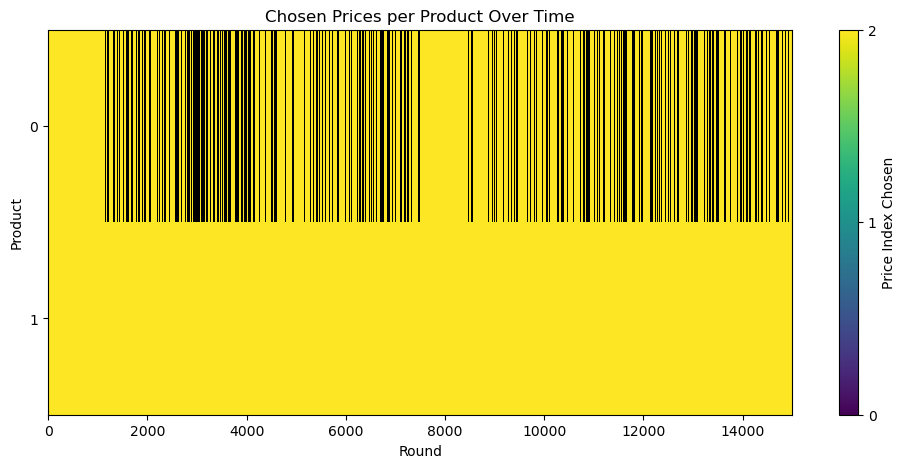

In [9]:
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.pyplot as plt

# Create a matrix: products × rounds
price_matrix = np.zeros((N, T_total))

for t in range(T_total):
    for i in range(N):
        price_matrix[i, t] = prices_per_round[t][i]  # -1 if not chosen

plt.figure(figsize=(12,5))

# Use a discrete colormap and set a specific color for -1
cmap = plt.cm.viridis
cmap.set_under(color='black')  # -1 will appear black

im = plt.imshow(price_matrix, aspect='auto', cmap=cmap, interpolation='nearest', vmin=0)

cbar = plt.colorbar(im)
cbar.set_label('Price Index Chosen')

cbar.set_ticks(np.arange(0, P))
cbar.set_ticklabels([str(i) for i in range(P)])

plt.xlabel("Round")
plt.ylabel("Product")
plt.yticks(np.arange(N))
plt.title("Chosen Prices per Product Over Time")
plt.show()


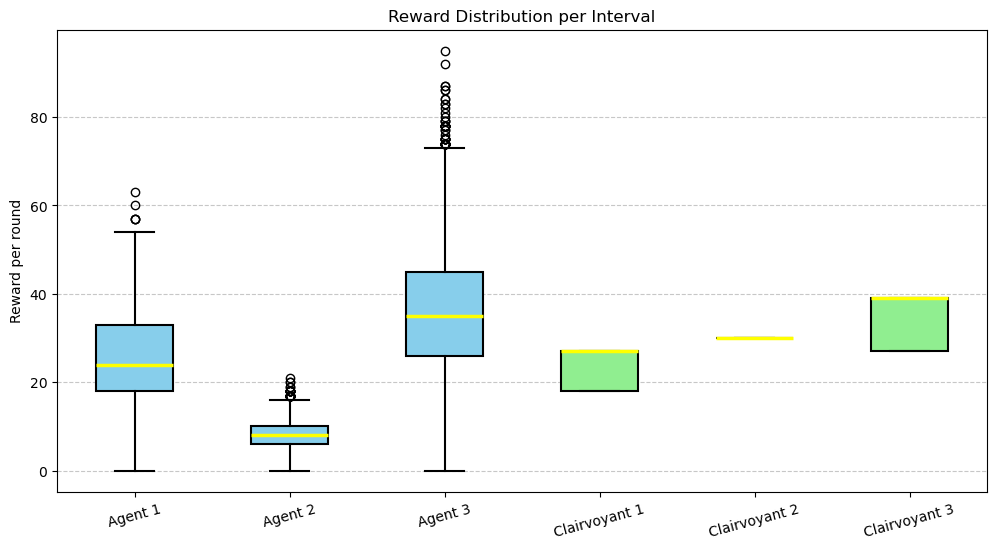

In [10]:
import matplotlib.pyplot as plt
import numpy as np

interval_bounds = [(int(interval['start']), int(interval['end'])) for interval in intervals]

agent_rewards_per_interval = [agent_rewards[t0:t1] for t0, t1 in interval_bounds]
clair_rewards_per_interval = [clair_rewards[t0:t1] for t0, t1 in interval_bounds]

all_boxes = agent_rewards_per_interval + clair_rewards_per_interval
labels = [f"Agent {i+1}" for i in range(len(intervals))] + \
         [f"Clairvoyant {i+1}" for i in range(len(intervals))]

plt.figure(figsize=(12,6))

boxprops = dict(linestyle='-', linewidth=1.5, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='yellow')
whiskerprops = dict(linewidth=1.5, color='black')
capprops = dict(linewidth=1.5, color='black')

bplot = plt.boxplot(all_boxes, labels=labels, patch_artist=True,
                    boxprops=boxprops, medianprops=medianprops,
                    whiskerprops=whiskerprops, capprops=capprops)

colors = ['skyblue'] * len(agent_rewards_per_interval) + ['lightgreen'] * len(clair_rewards_per_interval)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel("Reward per round")
plt.title("Reward Distribution per Interval")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.show()
